In [1]:
import numpy as np
import pandas as pd
# import boto3
import tensorflow as tf
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from tensorflow.python.client import device_lib
from keras.constraints import maxnorm
from keras.layers import Dropout
import time
import warnings
warnings.filterwarnings("ignore")


2023-04-20 14:56:10.290731: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-20 14:56:11.022108: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-20 14:56:11.026684: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-20 14:56:13.222881: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from keras.utils import pad_sequences
from tensorflow.keras.layers import Embedding

In [3]:
from collections import Counter
import itertools

In [4]:
from sklearn.model_selection import train_test_split

In [75]:
# from keras.preprocessing.sequence import pad_sequences
# from keras.layers.embeddings import Embedding
# from tensorflow.keras.layers import Embedding
#from keras.preprocessing import sequence

In [5]:
dff = pd.read_csv('../../../../datasets/sherloc/sherloc-court-case-token-back-to-text.csv')
dff.head(2)

,raw_text,crime_types,sentence,tokenized_cleaned_text,lemmatized,tokens_back_to_text
0,Mr. Solomon Sauls ran an illegal enterprise wi...,money laundry,1,"['solomon', 'sauls', 'ran', 'illegal', 'enterp...","['solomon', 'saul', 'ran', 'illegal', 'enterpr...",solomon saul ran illegal enterprise purpose po...
1,SummaryHarmony Gold Mine (Pty) Limited is a mi...,money laundry,1,"['summaryharmony', 'gold', 'mine', 'pty', 'lim...","['summaryharmony', 'gold', 'mine', 'pty', 'lim...",summaryharmony gold mine pty limited mining co...


In [6]:
len(dff)

1250

In [7]:
X = dff.tokens_back_to_text.values

In [55]:
y = dff.sentence.values

In [20]:
XX = list(dff.tokens_back_to_text)

In [9]:
X.shape, y.shape

((1250,), (1250,))

## Feature Engineering

In [10]:
# prepare tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

In [17]:
X

array(['solomon saul ran illegal enterprise purpose poach sell abalone haliotis midae south africa group abalone diver work supply illegally harvest abalone accuse bribed official department agriculture forestry fishery prevent confiscate abalone buy back abalone already seize authority corrupt official face charge separate march police search accuse house encounter cash accuse confess proceeds illegal activity february defendant plead guilty count involve run illegal enterprise corruption money laundering possess transport illegally harvest aggravate sentence seriousness corrupt government official engagement illegal abalone trade commercial scale financial accuse involve similar crime past previously receive prison sentence involvement another illegal enterprise focus abalone found responsible run illegal abalone business different area hand current trial solomon saul sentence year imprisonment run concurrently result effective sentence year determine run concurrently previous senten

In [11]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 11260 unique tokens.


In [12]:
# integer encode the documents
sequences = tokenizer.texts_to_sequences(X)

In [109]:
# pad documents to a max length of 14 words
maxlen = 25
X = pad_sequences(sequences, maxlen=maxlen)

In [110]:
X.shape

(1250, 25)

In [76]:
X

array([[  42, 1124,  174, ...,  959,   35,   24],
       [1242,  589,  149, ..., 1724,   50,  905],
       [1242,   96,   27, ...,  770,   95, 4559],
       ...,
       [   0,    0,    0, ...,  251,  643,   14],
       [  27, 3044,  146, ...,   52, 1167,  115],
       [  13,    2,  524, ..., 1690,  232,  124]], dtype=int32)

In [111]:
y = dff.sentence.values
counter = Counter(y)
print(counter)

Counter({1: 882, 0: 368})


### SMOTE - balance the imbalanced dataset

In [78]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
# define pipeline
over = SMOTE(sampling_strategy=0.5)
under = RandomUnderSampler(sampling_strategy=0.8)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
# transform the dataset
X, y = pipeline.fit_resample(X, y)

In [79]:
y.shape, X.shape

((992,), (992, 25))

In [80]:
counter = Counter(y)
print(counter)

Counter({1: 551, 0: 441})


### categorized y

In [112]:
# One-hot encoding of labels
from keras.utils.np_utils import to_categorical
y = to_categorical(y)

In [113]:
y.shape

(1250, 2)

### Split the dataset into training and test sets

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)

In [115]:
X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, test_size=0.2, random_state=43)

In [116]:
X_train.shape, X_test.shape, X_eval.shape

((800, 25), (250, 25), (200, 25))

## Modeling - Simple RNN and LSTM

In [117]:
# Prepare hyperparameters of RNN
vocab_size = len(word_index)+1
output_dim = 32

In [118]:
# SimpleRNN
warnings.filterwarnings("ignore")
model = Sequential()
model.add(Embedding(input_dim = vocab_size, output_dim = output_dim, input_length = maxlen, embeddings_constraint=maxnorm(3)))
model.add(SimpleRNN(output_dim, return_sequences=True, kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(SimpleRNN(output_dim, return_sequences=True, kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(SimpleRNN(output_dim))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
warnings.filterwarnings("ignore")

In [119]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 25, 32)            360352    
                                                                 
 simple_rnn_9 (SimpleRNN)    (None, 25, 32)            2080      
                                                                 
 dropout_12 (Dropout)        (None, 25, 32)            0         
                                                                 
 simple_rnn_10 (SimpleRNN)   (None, 25, 32)            2080      
                                                                 
 dropout_13 (Dropout)        (None, 25, 32)            0         
                                                                 
 simple_rnn_11 (SimpleRNN)   (None, 32)                2080      
                                                                 
 dense_6 (Dense)             (None, 2)                

In [120]:
start = time.time()

# Fit the model to the training set
rnn_hist = model.fit(X_train, y_train, epochs=10, validation_split=0.3)
# Final evaluation of the model
rnn_scores = model.evaluate(X_eval, y_eval, verbose=0)
print("Accuracy: %.2f%%" % (rnn_scores[1]*100))
warnings.filterwarnings("ignore")

end = time.time()
total = (end-start)/60
print('Training duration(minutes): {}'.format(total))

Epoch 1/10
18/18 [==============================] - 4s 49ms/step - loss: 0.6332 - accuracy: 0.6821 - val_loss: 0.6116 - val_accuracy: 0.6917
Epoch 2/10
18/18 [==============================] - 0s 26ms/step - loss: 0.4794 - accuracy: 0.7893 - val_loss: 0.5794 - val_accuracy: 0.7083
Epoch 3/10
18/18 [==============================] - 1s 32ms/step - loss: 0.2241 - accuracy: 0.9732 - val_loss: 0.6262 - val_accuracy: 0.6750
Epoch 4/10
18/18 [==============================] - 1s 29ms/step - loss: 0.0728 - accuracy: 0.9964 - val_loss: 0.6702 - val_accuracy: 0.6750
Epoch 5/10
18/18 [==============================] - 1s 29ms/step - loss: 0.0413 - accuracy: 0.9964 - val_loss: 0.7228 - val_accuracy: 0.6625
Epoch 6/10
18/18 [==============================] - 0s 25ms/step - loss: 0.0306 - accuracy: 0.9964 - val_loss: 0.7638 - val_accuracy: 0.6833
Epoch 7/10
18/18 [==============================] - 0s 26ms/step - loss: 0.0270 - accuracy: 0.9946 - val_loss: 0.7637 - val_accuracy: 0.6792
Epoch 8/10
18

In [140]:
rnn_scores

[0.9833414554595947, 0.7549999952316284]

In [121]:
# Save the LSTM model
model.save('srnn.h5')

In [145]:
# LSTM
model = Sequential()
model.add(Embedding(input_dim = vocab_size, output_dim = output_dim, input_length = maxlen, embeddings_constraint=maxnorm(3)))
model.add(LSTM(20, return_sequences=True, kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(LSTM(10, return_sequences=True, kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(LSTM(5, kernel_constraint=maxnorm(3)))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
warnings.filterwarnings("ignore")

2023-04-20 15:54:43.639780: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-20 15:54:43.641867: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-20 15:54:43.643518: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [146]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 25, 32)            360352    
                                                                 
 lstm_15 (LSTM)              (None, 25, 20)            4240      
                                                                 
 dropout_18 (Dropout)        (None, 25, 20)            0         
                                                                 
 lstm_16 (LSTM)              (None, 25, 10)            1240      
                                                                 
 dropout_19 (Dropout)        (None, 25, 10)            0         
                                                                 
 lstm_17 (LSTM)              (None, 5)                 320       
                                                                 
 dense_9 (Dense)             (None, 2)                

In [147]:
# Save the LSTM model
model.save('lstm.h5')

In [148]:
start = time.time()

# Fit the model to the training set
lstm_hist = model.fit(X_train, y_train, epochs=10, validation_split=0.3)
# Final evaluation of the model
warnings.filterwarnings("ignore")
lstm_scores = model.evaluate(X_eval, y_eval, verbose=0)
print("Accuracy: %.2f%%" % (lstm_scores[1]*100))
warnings.filterwarnings("ignore")
end = time.time()
total = (end-start)/60
print('Training duration(minutes): {}'.format(total))

Epoch 1/10


2023-04-20 15:54:47.548467: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-20 15:54:47.550398: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-20 15:54:47.552087: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

17/18 [===========================>..] - ETA: 0s - loss: 0.6384 - accuracy: 0.7096

2023-04-20 15:54:53.016805: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-20 15:54:53.018496: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-20 15:54:53.019788: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

18/18 [==============================] - 7s 98ms/step - loss: 0.6367 - accuracy: 0.7107 - val_loss: 0.6116 - val_accuracy: 0.6917
Epoch 2/10
18/18 [==============================] - 1s 42ms/step - loss: 0.5634 - accuracy: 0.7196 - val_loss: 0.5993 - val_accuracy: 0.6917
Epoch 3/10
18/18 [==============================] - 1s 40ms/step - loss: 0.4172 - accuracy: 0.8000 - val_loss: 0.5100 - val_accuracy: 0.7750
Epoch 4/10
18/18 [==============================] - 1s 39ms/step - loss: 0.1987 - accuracy: 0.9786 - val_loss: 0.5975 - val_accuracy: 0.7542
Epoch 5/10
18/18 [==============================] - 1s 39ms/step - loss: 0.1399 - accuracy: 0.9875 - val_loss: 0.6625 - val_accuracy: 0.7042
Epoch 6/10
18/18 [==============================] - 1s 39ms/step - loss: 0.1074 - accuracy: 0.9946 - val_loss: 0.7264 - val_accuracy: 0.6833
Epoch 7/10
18/18 [==============================] - 1s 39ms/step - loss: 0.0870 - accuracy: 0.9964 - val_loss: 0.7148 - val_accuracy: 0.7375
Epoch 8/10
18/18 [======

In [ ]:
lstm_score

In [126]:
# Accuracy
# maxlen = 100
srnn_acc = 60.38
lstm_acc = 67.92
# maxlen = 50
srnn_acc = 53.46
lstm_acc = 70.44
# maxlen = 25
srnn_acc = 60.38
lstm_acc = 71.70

### Model Evaluation

#### SimpleRNN Result

In [127]:
# rnn_hist.history

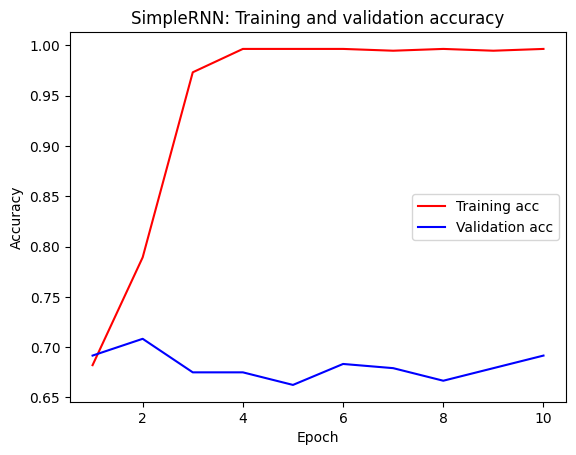

In [128]:
import matplotlib.pyplot as plt
acc = rnn_hist.history['accuracy']
val_acc = rnn_hist.history['val_accuracy']
loss = rnn_hist.history['loss']
val_loss = rnn_hist.history['val_loss']
epochs = range(1, len(acc)+1)
_ = plt.plot(epochs, acc, 'r', label='Training acc')
_ = plt.plot(epochs, val_acc, 'b', label='Validation acc')
_ = plt.title('SimpleRNN: Training and validation accuracy')
_ = plt.xlabel('Epoch')
_ = plt.ylabel('Accuracy')
_ = plt.legend(loc='best')
plt.show()

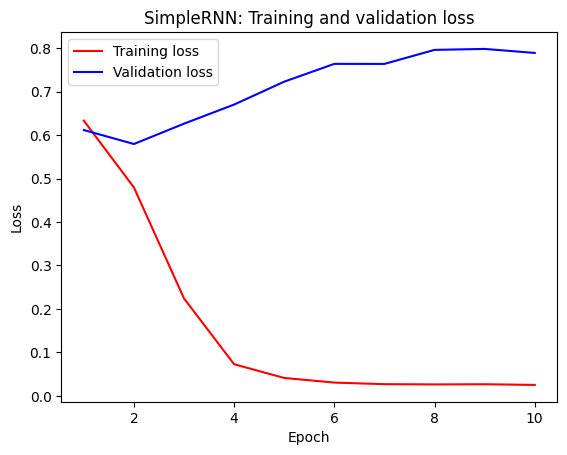

In [129]:
_ = plt.plot(epochs, loss, 'r', label='Training loss')
_ = plt.plot(epochs, val_loss, 'b', label='Validation loss')
_ = plt.title('SimpleRNN: Training and validation loss')
_ = plt.xlabel('Epoch')
_ = plt.ylabel('Loss')
_ = plt.legend(loc='best')
plt.show()

#### LSTM Result

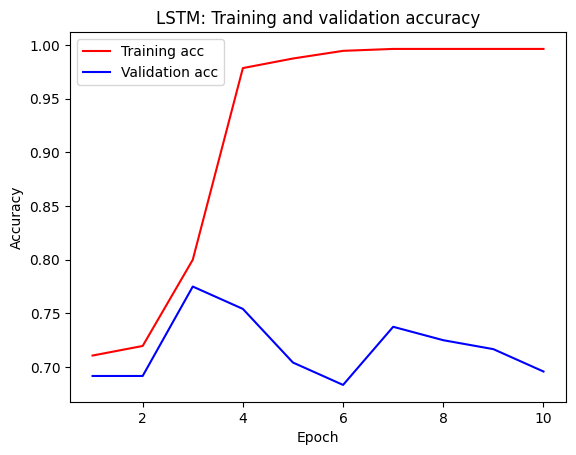

In [149]:
import matplotlib.pyplot as plt
acc = lstm_hist.history['accuracy']
val_acc = lstm_hist.history['val_accuracy']
loss = lstm_hist.history['loss']
val_loss = lstm_hist.history['val_loss']
epochs = range(1, len(acc)+1)
_ = plt.plot(epochs, acc, 'r', label='Training acc')
_ = plt.plot(epochs, val_acc, 'b', label='Validation acc')
_ = plt.title('LSTM: Training and validation accuracy')
_ = plt.xlabel('Epoch')
_ = plt.ylabel('Accuracy')
_ = plt.legend(loc='best')
plt.show()

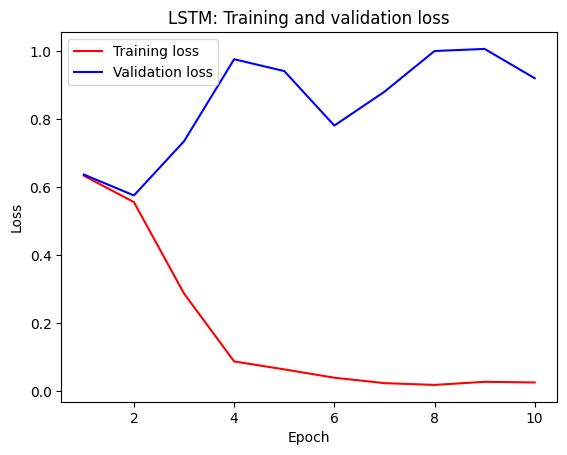

In [131]:
_ = plt.plot(epochs, loss, 'r', label='Training loss')
_ = plt.plot(epochs, val_loss, 'b', label='Validation loss')
_ = plt.title('LSTM: Training and validation loss')
_ = plt.xlabel('Epoch')
_ = plt.ylabel('Loss')
_ = plt.legend(loc='best')
plt.show()

### Predict with the LSTM model

In [132]:
from keras.models import load_model
lstm = load_model('lstm.h5')
warnings.filterwarnings("ignore")

2023-04-20 15:18:11.714216: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-20 15:18:11.718232: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-20 15:18:11.720163: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [133]:
lstm.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 25, 32)            360352    
                                                                 
 lstm_9 (LSTM)               (None, 25, 32)            8320      
                                                                 
 dropout_14 (Dropout)        (None, 25, 32)            0         
                                                                 
 lstm_10 (LSTM)              (None, 25, 32)            8320      
                                                                 
 dropout_15 (Dropout)        (None, 25, 32)            0         
                                                                 
 lstm_11 (LSTM)              (None, 32)                8320      
                                                                 
 dense_7 (Dense)             (None, 2)                

In [134]:
# list(itertools.chain.from_iterable(X_test))
Counter(list(itertools.chain.from_iterable(y_test)))

Counter({0.0: 250, 1.0: 250})

In [135]:
predictions = lstm.predict(X_test)

2023-04-20 15:21:23.956803: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-20 15:21:23.959581: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-20 15:21:23.961423: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

8/8 [==============================] - 1s 9ms/step


In [136]:
predictions[:,0]

array([0.4977959 , 0.5026902 , 0.49809253, 0.49969834, 0.5015027 ,
       0.4998441 , 0.5032908 , 0.5004094 , 0.5027386 , 0.50071347,
       0.50179887, 0.50000525, 0.4990157 , 0.4989892 , 0.50030094,
       0.49926868, 0.4987393 , 0.49897572, 0.5016884 , 0.5028844 ,
       0.50054395, 0.49963805, 0.50085956, 0.49990064, 0.49873143,
       0.5006212 , 0.4957953 , 0.50064   , 0.49950296, 0.5027653 ,
       0.5019367 , 0.5001731 , 0.49828714, 0.50042295, 0.49957097,
       0.50081193, 0.50113887, 0.49812904, 0.5019777 , 0.5023559 ,
       0.49939936, 0.50176233, 0.4996788 , 0.49840486, 0.50141567,
       0.50105625, 0.4998655 , 0.50376856, 0.50192934, 0.49991187,
       0.5020288 , 0.5000674 , 0.500017  , 0.5001889 , 0.5013401 ,
       0.4980401 , 0.49879977, 0.5006904 , 0.49789956, 0.498689  ,
       0.49958688, 0.49945146, 0.5001643 , 0.4996829 , 0.50119245,
       0.49970874, 0.5014302 , 0.4986328 , 0.50094   , 0.49905944,
       0.50124335, 0.5014457 , 0.4993706 , 0.4991633 , 0.49878

In [137]:
probability_positive = predictions[:,1]

In [138]:
len(probability_positive)

250

In [139]:
probability_positive

array([0.5022041 , 0.4973097 , 0.50190747, 0.5003016 , 0.4984973 ,
       0.5001558 , 0.4967092 , 0.49959064, 0.49726146, 0.49928668,
       0.49820113, 0.4999948 , 0.5009843 , 0.50101084, 0.4996991 ,
       0.5007313 , 0.50126064, 0.50102425, 0.49831152, 0.49711567,
       0.4994561 , 0.5003619 , 0.49914035, 0.5000993 , 0.5012686 ,
       0.49937865, 0.50420463, 0.49936008, 0.50049704, 0.49723464,
       0.49806336, 0.49982676, 0.5017128 , 0.49957705, 0.50042903,
       0.4991881 , 0.4988612 , 0.501871  , 0.49802223, 0.4976441 ,
       0.5006007 , 0.49823767, 0.5003211 , 0.5015951 , 0.4985843 ,
       0.49894372, 0.5001344 , 0.49623144, 0.49807063, 0.5000881 ,
       0.49797118, 0.4999326 , 0.49998298, 0.4998112 , 0.49865994,
       0.5019598 , 0.5012002 , 0.49930957, 0.50210035, 0.50131106,
       0.5004132 , 0.5005486 , 0.49983558, 0.50031704, 0.49880764,
       0.5002912 , 0.4985698 , 0.5013672 , 0.49906   , 0.50094056,
       0.4987567 , 0.49855426, 0.50062925, 0.5008367 , 0.50121